# Inspeção de Qualidade - Benchmark de Modelos de Aprendizado de Máquina

## Objetivo
Testar a inspeção de qualidade automatizada usando modelos de aprendizado de máquina de visão computacional
Este repositório avaliará modelos de aprendizado de máquina (InceptionResNetv2, Xception, MobileNet e um modelo personalizado)

## Conjunto de dados

O conjunto de dados utilizado é da Pilot Technocast, uma empresa localizada em Gujarat, Índia, especializada na fabricação de produtos fundidos. O conjunto de dados, composto por 7348 imagens de vista superior de rotores de bomba submersível feitos de aço inoxidável por meio de um processo de moldagem em concha, foi disponibilizado publicamente por Ravirajsinh Dabhi. As imagens foram redimensionadas para 300 x 300 pixels e foram coletadas usando um kit de câmera Canon EOS 1300D sob iluminação estável. Os dados são pré-rotulados em duas categorias, a saber, 'def_front' e 'ok_front', representando produtos defeituosos e aceitáveis, respectivamente.

In [70]:
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from keras.preprocessing import image 
from keras.models import Sequential
from sklearn import metrics

In [71]:
# Usando a GPU em um Mac M1

physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    tf.config.set_visible_devices(physical_devices[0], 'GPU')
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [72]:
# definindo variáveis de diretório
root_dir = 'archive/casting_data/casting_data/'
train_defective = root_dir + 'train/def_front/'
train_ok = root_dir + 'train/ok_front/'

test_defective = root_dir + 'test/def_front/'
test_ok = root_dir + 'test/ok_front/'

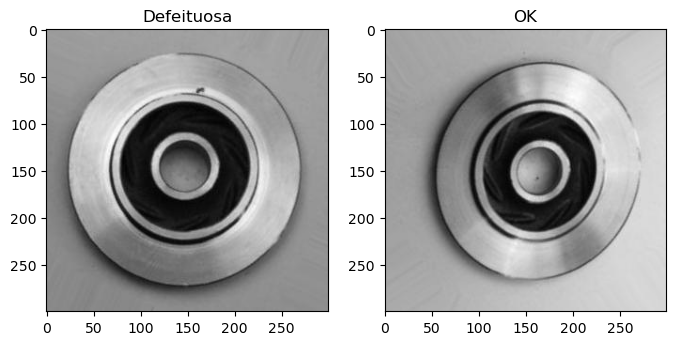

In [73]:
# Plotando imagens

fig, axes = plt.subplots(1, 2, figsize=(8,4))
axes[0].imshow(plt.imread(train_defective+os.listdir(train_defective)[0]))
axes[1].imshow(plt.imread(train_ok+os.listdir(train_ok)[0]))
axes[0].set_title('Defeituosa')
axes[1].set_title('OK')
plt.show()

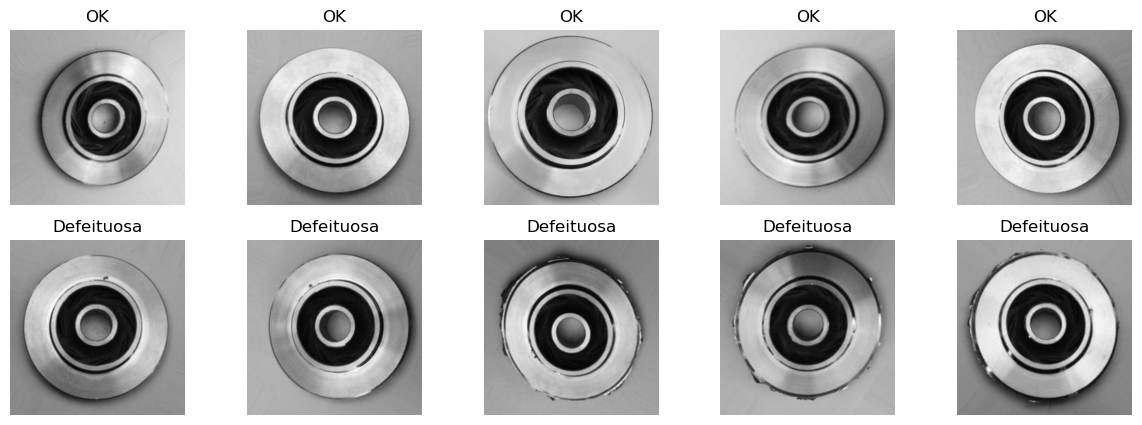

In [74]:
# 5 imagens de cada rótulo - conjunto de treinamento

# definir o número de imagens a plotar para cada rótulo
num_images = 5

# criacao de uma figura com duas linhas e num_images colunas
fig, axs = plt.subplots(nrows=2, ncols=num_images, figsize=(15,5))

# plot das imagens ok
for i, filename in enumerate(os.listdir(train_ok)[:num_images]):
    img = plt.imread(train_ok + filename)
    axs[0,i].imshow(img)
    axs[0,i].set_title('OK')
    axs[0,i].axis('off')

# plot das imagens defeituosas
for i, filename in enumerate(os.listdir(train_defective)[:num_images]):
    img = plt.imread(train_defective + filename)
    axs[1,i].imshow(img)
    axs[1,i].set_title('Defeituosa')
    axs[1,i].axis('off')

# ajuste do espaçamento entre as subplots

plt.subplots_adjust(wspace=0.1, hspace=0.2)

# mostra do plot
plt.show()


### Análise exploratória dos dados


- Número de imagens


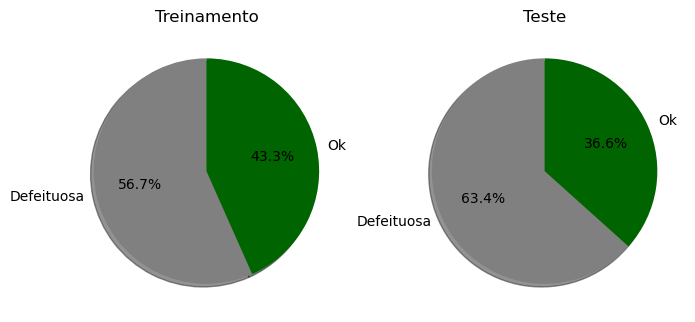

 Treinamento: Imagens Defeituosas 	: 3758
 Treinamento: Imagens Ok 		: 2875

 Teste: Imagens Defeituosas 	: 453
 Teste: Imagens Ok 		: 262


In [75]:
x_train = np.array([len(os.listdir(train_defective)),len(os.listdir(train_ok))])
x_test = np.array([len(os.listdir(test_defective)),len(os.listdir(test_ok))])
label = ['Defeituosa','Ok']
colors = ['grey', 'darkgreen']
  
fig, axes = plt.subplots(1, 2, figsize=(8,4))
axes[0].pie(x_train, labels=label, autopct='%1.1f%%',shadow=True, startangle=90, colors=colors)
axes[1].pie(x_test, labels=label, autopct='%1.1f%%',shadow=True, startangle=90, colors=colors)
axes[0].set_title('Treinamento')
axes[1].set_title('Teste')
plt.show()

print(' Treinamento: Imagens Defeituosas \t: ' + str(len(os.listdir(train_defective))))
print(' Treinamento: Imagens Ok \t\t: ' + str(len(os.listdir(train_ok))))
print()
print(' Teste: Imagens Defeituosas \t: ' + str(len(os.listdir(test_defective))))
print(' Teste: Imagens Ok \t\t: ' + str(len(os.listdir(test_ok))))

## Carregamento e pré-processamento dos dados

- Normalização 
- tamanho de entrada das imagens para a CNN (300x300)
- Definicao binaria e RGB

In [76]:
# Geral
# Utilizando IDG para carregar imagens do diretório
train_idg = ImageDataGenerator(rescale=1./255, validation_split=0.3) # 30% de separação para validação do treinamento 
test_idg = ImageDataGenerator(rescale=1./255)

# Especificação de parâmetros/argumentos para a geração de dados
img_size = (300, 300)
batch_size = 64

arg_train = {'target_size': img_size,
             'color_mode': 'rgb',
             'class_mode': 'binary',
             'batch_size': batch_size}
arg_test = {'target_size': img_size,
            'color_mode': 'rgb',
            'class_mode': 'binary',
            'batch_size': batch_size,
            'shuffle': False}

train = train_idg.flow_from_directory(directory=root_dir+'train/', subset='training', **arg_train)
valid = train_idg.flow_from_directory(directory=root_dir+'train/', subset='validation', **arg_train)
test  = test_idg.flow_from_directory(directory=root_dir+'test/', **arg_test)

Found 4644 images belonging to 2 classes.
Found 1989 images belonging to 2 classes.
Found 715 images belonging to 2 classes.


In [77]:
#Xception
# Utilizando IDG para carregar imagens do diretório
train_idgx = ImageDataGenerator(rescale=1./255, validation_split=0.3) # 30% de separação para validação do treinamento 
test_idgx = ImageDataGenerator(rescale=1./255)

# Especificação de parâmetros/argumentos para a geração de dados
img_sizex = (300, 300)
batch_sizex = 64

arg_trainx = {'target_size': img_sizex,
             'color_mode': 'rgb',
             'class_mode': 'binary',
             'batch_size': batch_sizex}
arg_testx = {'target_size': img_sizex,
            'color_mode': 'rgb',
            'class_mode': 'binary',
            'batch_size': batch_sizex,
            'shuffle': False}

trainx = train_idgx.flow_from_directory(directory=root_dir+'train/', subset='training', **arg_train)
validx = train_idgx.flow_from_directory(directory=root_dir+'train/', subset='validation', **arg_train)
testx  = test_idgx.flow_from_directory(directory=root_dir+'test/', **arg_test)

Found 4644 images belonging to 2 classes.
Found 1989 images belonging to 2 classes.
Found 715 images belonging to 2 classes.


In [78]:
#InceptionResnvetV2
# Utilizando IDG para carregar imagens do diretório
train_idgi = ImageDataGenerator(rescale=1./255, validation_split=0.3) # 30% de separação para validação do treinamento 
test_idgi = ImageDataGenerator(rescale=1./255)

# Especificação de parâmetros/argumentos para a geração de dados
img_sizei = (300, 300)
batch_sizei = 64

arg_traini = {'target_size': img_sizei,
             'color_mode': 'rgb',
             'class_mode': 'binary',
             'batch_size': batch_sizei}
arg_testi = {'target_size': img_sizei,
            'color_mode': 'rgb',
            'class_mode': 'binary',
            'batch_size': batch_sizei,
            'shuffle': False}

traini = train_idgi.flow_from_directory(directory=root_dir+'train/', subset='training', **arg_train)
validi = train_idgi.flow_from_directory(directory=root_dir+'train/', subset='validation', **arg_train)
testi  = test_idgi.flow_from_directory(directory=root_dir+'test/', **arg_test)

Found 4644 images belonging to 2 classes.
Found 1989 images belonging to 2 classes.
Found 715 images belonging to 2 classes.


In [79]:
#MobileNet
# Utilizando IDG para carregar imagens do diretório
train_idgm = ImageDataGenerator(rescale=1./255, validation_split=0.3) # 30% de separação para validação do treinamento 
test_idgm = ImageDataGenerator(rescale=1./255)

# Especificação de parâmetros/argumentos para a geração de dados
img_sizem = (300, 300)
batch_sizem = 64

arg_trainm = {'target_size': img_sizem,
             'color_mode': 'rgb',
             'class_mode': 'binary',
             'batch_size': batch_sizem}
arg_testm = {'target_size': img_sizem,
            'color_mode': 'rgb',
            'class_mode': 'binary',
            'batch_size': batch_sizem,
            'shuffle': False}

trainm = train_idgm.flow_from_directory(directory=root_dir+'train/', subset='training', **arg_train)
validm = train_idgm.flow_from_directory(directory=root_dir+'train/', subset='validation', **arg_train)
testm  = test_idgm.flow_from_directory(directory=root_dir+'test/', **arg_test)

Found 4644 images belonging to 2 classes.
Found 1989 images belonging to 2 classes.
Found 715 images belonging to 2 classes.


In [80]:
#MobileNetV2
# Utilizando IDG para carregar imagens do diretório
train_idgm2 = ImageDataGenerator(rescale=1./255, validation_split=0.3) # 30% de separação para validação do treinamento 
test_idgm2 = ImageDataGenerator(rescale=1./255)

# Especificação de parâmetros/argumentos para a geração de dados
img_sizem2 = (300, 300)
batch_sizem2 = 64

arg_trainm2 = {'target_size': img_sizem2,
             'color_mode': 'rgb',
             'class_mode': 'binary',
             'batch_size': batch_sizem2}
arg_testm2 = {'target_size': img_sizem2,
            'color_mode': 'rgb',
            'class_mode': 'binary',
            'batch_size': batch_sizem2,
            'shuffle': False}

trainm2 = train_idgm2.flow_from_directory(directory=root_dir+'train/', subset='training', **arg_train)
validm2 = train_idgm2.flow_from_directory(directory=root_dir+'train/', subset='validation', **arg_train)
testm2  = test_idgm2.flow_from_directory(directory=root_dir+'test/', **arg_test)

Found 4644 images belonging to 2 classes.
Found 1989 images belonging to 2 classes.
Found 715 images belonging to 2 classes.


## CNN
Modelos Xception, InceptionResnetV2, MobileNet e MobileNetV2

In [81]:
from tensorflow.keras.applications import Xception
xcept = Xception(input_shape = (300, 300, 3), include_top = False, weights = 'imagenet')

In [82]:
from tensorflow.keras.applications import InceptionResNetV2
incresnv2 = InceptionResNetV2(input_shape = (300, 300, 3), include_top = False, weights = 'imagenet')

In [83]:
from tensorflow.keras.applications import MobileNet
mobilenet = MobileNet(input_shape = (300, 300, 3), include_top = False, weights = 'imagenet')

In [84]:
from tensorflow.keras.applications import MobileNetV2
mobilenetv2 = MobileNetV2(input_shape = (300, 300, 3), include_top = False, weights = 'imagenet')

### Construindo os modelos

In [85]:
# Xception

import os
import numpy as np
import pandas as pd
import keras
from keras.layers import Conv2D, MaxPool2D,Dropout,Flatten,Dense
from keras.preprocessing import image 
from keras.models import Sequential
import tensorflow as tf
from tensorflow.keras import models
import datetime

for layer in xcept.layers:
    layer.trainable = False

cnnx = keras.Sequential([
    xcept,
    keras.layers.Flatten(),
    keras.layers.Dense(units=256, activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=1, activation="sigmoid"),
])

cnnx.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

cnnx.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 flatten_8 (Flatten)         (None, 204800)            0         
                                                                 
 dense_16 (Dense)            (None, 256)               52429056  
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 dense_17 (Dense)            (None, 1)                 257       
                                                                 
Total params: 73,290,793
Trainable params: 52,429,313
Non-trainable params: 20,861,480
_________________________________________________________________


In [86]:
# InceptionResnetV2

import os
import numpy as np
import pandas as pd
import keras
from keras.layers import Conv2D, MaxPool2D,Dropout,Flatten,Dense
from keras.preprocessing import image 
from keras.models import Sequential
import tensorflow as tf
from tensorflow.keras import models
import datetime

for layer in inciresnv2.layers:
    layer.trainable = False

cnni = keras.Sequential([
    inciresnv2,
    keras.layers.Flatten(),
    keras.layers.Dense(units=256, activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=1, activation="sigmoid"),
])

cnni.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

cnni.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 8, 8, 1536)       54336736  
 onal)                                                           
                                                                 
 flatten_9 (Flatten)         (None, 98304)             0         
                                                                 
 dense_18 (Dense)            (None, 256)               25166080  
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 dense_19 (Dense)            (None, 1)                 257       
                                                                 
Total params: 79,503,073
Trainable params: 25,166,337
Non-trainable params: 54,336,736
_________________________________

In [87]:
# MobileNet

import os
import numpy as np
import pandas as pd
import keras
from keras.layers import Conv2D, MaxPool2D,Dropout,Flatten,Dense
from keras.preprocessing import image 
from keras.models import Sequential
import tensorflow as tf
from tensorflow.keras import models
import datetime

for layer in mobilenet.layers:
    layer.trainable = False

cnnm = keras.Sequential([
    mobilenet,
    keras.layers.Flatten(),
    keras.layers.Dense(units=256, activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=1, activation="sigmoid"),
])

cnnm.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

cnnm.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 9, 9, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten_10 (Flatten)        (None, 82944)             0         
                                                                 
 dense_20 (Dense)            (None, 256)               21233920  
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_21 (Dense)            (None, 1)                 257       
                                                                 
Total params: 24,463,041
Trainable params: 21,234,177
Non-trainable params: 3,228,864
_________________________________

In [88]:
# MobileNetV2

import os
import numpy as np
import pandas as pd
import keras
from keras.layers import Conv2D, MaxPool2D,Dropout,Flatten,Dense
from keras.preprocessing import image 
from keras.models import Sequential
import tensorflow as tf
from tensorflow.keras import models
import datetime

for layer in mobilenetv2.layers:
    layer.trainable = False

cnnm2 = keras.Sequential([
    mobilenetv2,
    keras.layers.Flatten(),
    keras.layers.Dense(units=256, activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=1, activation="sigmoid"),
])

cnnm2.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

cnnm2.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 10, 10, 1280)     2257984   
 ional)                                                          
                                                                 
 flatten_11 (Flatten)        (None, 128000)            0         
                                                                 
 dense_22 (Dense)            (None, 256)               32768256  
                                                                 
 dropout_11 (Dropout)        (None, 256)               0         
                                                                 
 dense_23 (Dense)            (None, 1)                 257       
                                                                 
Total params: 35,026,497
Trainable params: 32,768,513
Non-trainable params: 2,257,984
_________________________________

### Treinando os modelos

In [89]:
historyx = cnnx.fit(
    train,
    validation_data=valid,
    epochs=20,
    steps_per_epoch=20,
    verbose = 1
    )

Epoch 1/20


2023-04-26 09:35:59.014049: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-26 09:36:01.514923: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - ETA: 0s - loss: 6.7634 - accuracy: 0.7396

2023-04-26 09:37:24.935382: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-26 09:37:25.768501: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 198s 10s/step - loss: 6.7634 - accuracy: 0.7396 - val_loss: 0.3720 - val_accuracy: 0.9191
Epoch 2/20
20/20 [==============================] - ETA: 0s - loss: 0.3181 - accuracy: 0.9422

In [ ]:
historyi = cnni.fit(
    train,
    validation_data=valid,
    epochs=20,
    steps_per_epoch=20,
    verbose = 1
    )

Epoch 1/20


2023-04-25 11:38:38.047192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-25 11:38:43.042150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - ETA: 0s - loss: 20.0363 - accuracy: 0.5172

2023-04-25 11:39:32.928127: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-25 11:39:34.034169: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 127s 6s/step - loss: 20.0363 - accuracy: 0.5172 - val_loss: 0.3139 - val_accuracy: 0.8467
Epoch 2/20
20/20 [==============================] - 106s 5s/step - loss: 0.4061 - accuracy: 0.8047 - val_loss: 0.2130 - val_accuracy: 0.9110
Epoch 3/20
20/20 [==============================] - 111s 6s/step - loss: 0.2063 - accuracy: 0.9201 - val_loss: 0.1336 - val_accuracy: 0.9452
Epoch 4/20
20/20 [==============================] - 107s 6s/step - loss: 0.1466 - accuracy: 0.9377 - val_loss: 0.0933 - val_accuracy: 0.9713
Epoch 5/20
20/20 [==============================] - 114s 6s/step - loss: 0.1106 - accuracy: 0.9625 - val_loss: 0.0694 - val_accuracy: 0.9799
Epoch 6/20
20/20 [==============================] - 115s 6s/step - loss: 0.1021 - accuracy: 0.9625 - val_loss: 0.0636 - val_accuracy: 0.9854
Epoch 7/20
20/20 [==============================] - 115s 6s/step - loss: 0.0961 - accuracy: 0.9695 - val_loss: 0.0535 - val_accuracy: 0.9894
Epoch 8/20
20/20 [=====

In [ ]:
historym = cnnm.fit(
    train,
    validation_data=valid,
    epochs=20,
    steps_per_epoch=20,
    verbose = 1
    )

Epoch 1/20


2023-04-25 14:26:07.124915: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-25 14:26:08.111067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - ETA: 0s - loss: 8.8085 - accuracy: 0.6914

2023-04-25 14:26:20.785013: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-25 14:26:20.985778: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 28s 1s/step - loss: 8.8085 - accuracy: 0.6914 - val_loss: 0.3040 - val_accuracy: 0.9512
Epoch 2/20
20/20 [==============================] - 24s 1s/step - loss: 0.3989 - accuracy: 0.9383 - val_loss: 0.0905 - val_accuracy: 0.9864
Epoch 3/20
20/20 [==============================] - 24s 1s/step - loss: 0.0651 - accuracy: 0.9864 - val_loss: 0.0663 - val_accuracy: 0.9884
Epoch 4/20
20/20 [==============================] - 24s 1s/step - loss: 0.0218 - accuracy: 0.9945 - val_loss: 0.0434 - val_accuracy: 0.9910
Epoch 5/20
20/20 [==============================] - 23s 1s/step - loss: 0.0399 - accuracy: 0.9920 - val_loss: 0.0376 - val_accuracy: 0.9930
Epoch 6/20
20/20 [==============================] - 23s 1s/step - loss: 0.0371 - accuracy: 0.9883 - val_loss: 0.0411 - val_accuracy: 0.9894
Epoch 7/20
20/20 [==============================] - 23s 1s/step - loss: 0.0232 - accuracy: 0.9945 - val_loss: 0.0158 - val_accuracy: 0.9950
Epoch 8/20
20/20 [=============

In [ ]:
historym2 = cnnm2.fit(
    train,
    validation_data=valid,
    epochs=20,
    steps_per_epoch=20,
    verbose = 1
    )

Epoch 1/20


2023-04-25 16:59:23.339276: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-25 16:59:25.909239: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - ETA: 0s - loss: 22.1239 - accuracy: 0.6055

2023-04-25 16:59:57.731594: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-25 16:59:58.360416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 76s 4s/step - loss: 22.1239 - accuracy: 0.6055 - val_loss: 4.0038 - val_accuracy: 0.6088
Epoch 2/20
20/20 [==============================] - 59s 3s/step - loss: 1.9860 - accuracy: 0.8156 - val_loss: 0.3692 - val_accuracy: 0.9346
Epoch 3/20
20/20 [==============================] - 63s 3s/step - loss: 0.1844 - accuracy: 0.9586 - val_loss: 0.0936 - val_accuracy: 0.9804
Epoch 4/20
20/20 [==============================] - 65s 3s/step - loss: 0.0779 - accuracy: 0.9789 - val_loss: 0.0417 - val_accuracy: 0.9884
Epoch 5/20
20/20 [==============================] - 60s 3s/step - loss: 0.0380 - accuracy: 0.9912 - val_loss: 0.0425 - val_accuracy: 0.9879
Epoch 6/20
20/20 [==============================] - 57s 3s/step - loss: 0.0321 - accuracy: 0.9930 - val_loss: 0.0316 - val_accuracy: 0.9925
Epoch 7/20
20/20 [==============================] - 156s 8s/step - loss: 0.0265 - accuracy: 0.9945 - val_loss: 0.0272 - val_accuracy: 0.9915
Epoch 8/20
20/20 [===========

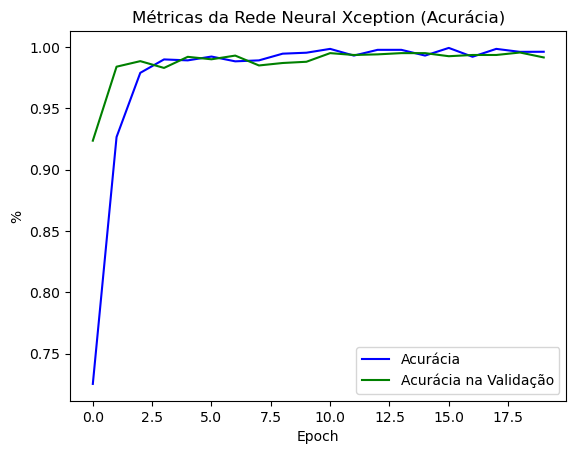

In [ ]:
plt.plot(historyx.history['accuracy'], color='blue', label='Acurácia')
plt.plot(historyx.history['val_accuracy'], color='green', label='Acurácia na Validação')
plt.title('Métricas da Rede Neural Xception (Acurácia)')
plt.ylabel('%')
plt.xlabel('Epoch')
plt.legend(loc="lower right")
plt.show()

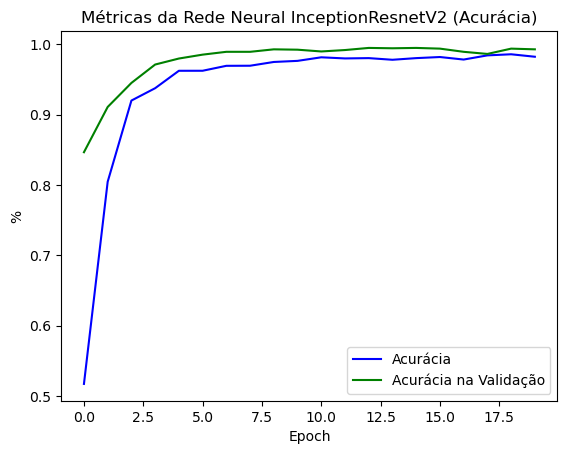

In [ ]:
plt.plot(historyi.history['accuracy'], color='blue', label='Acurácia')
plt.plot(historyi.history['val_accuracy'], color='green', label='Acurácia na Validação')
plt.title('Métricas da Rede Neural InceptionResnetV2 (Acurácia)')
plt.ylabel('%')
plt.xlabel('Epoch')
plt.legend(loc="lower right")
plt.show()

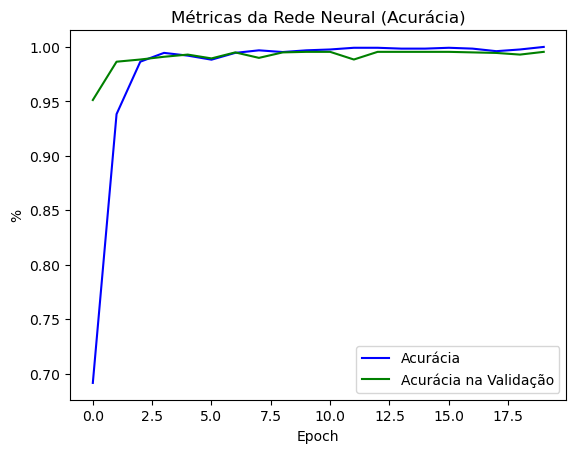

In [ ]:
plt.plot(historym.history['accuracy'], color='blue', label='Acurácia')
plt.plot(historym.history['val_accuracy'], color='green', label='Acurácia na Validação')
plt.title('Métricas da Rede Neural (Acurácia)')
plt.ylabel('%')
plt.xlabel('Epoch')
plt.legend(loc="lower right")
plt.show()

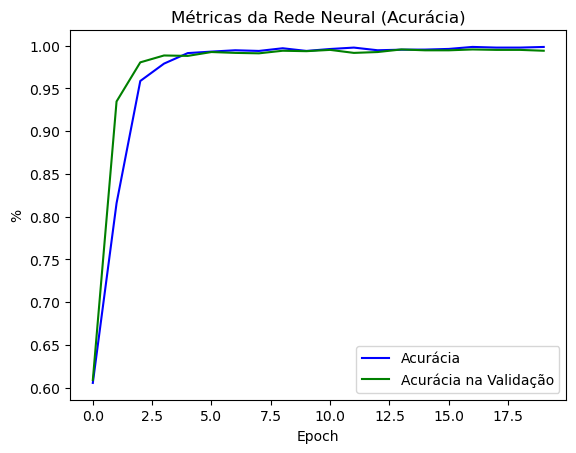

In [ ]:
plt.plot(historym2.history['accuracy'], color='blue', label='Acurácia')
plt.plot(historym2.history['val_accuracy'], color='green', label='Acurácia na Validação')
plt.title('Métricas da Rede Neural (Acurácia)')
plt.ylabel('%')
plt.xlabel('Epoch')
plt.legend(loc="lower right")
plt.show()

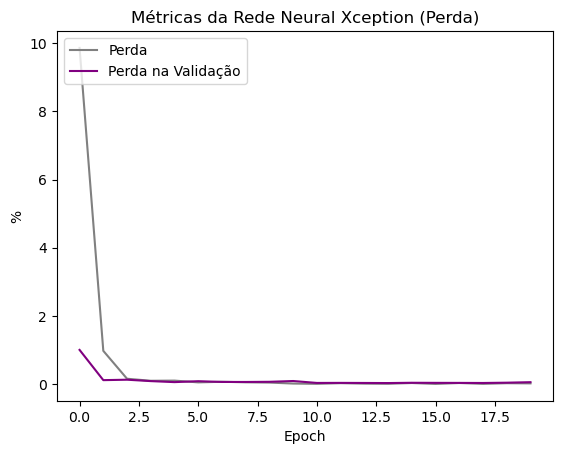

In [ ]:
plt.plot(historyx.history['loss'], color='grey', label='Perda')
plt.plot(historyx.history['val_loss'], color='purple', label='Perda na Validação')
plt.title('Métricas da Rede Neural Xception (Perda)')
plt.ylabel('%')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

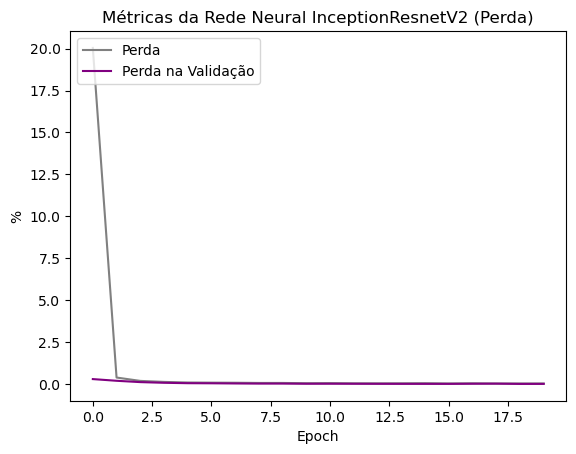

In [ ]:
plt.plot(historyi.history['loss'], color='grey', label='Perda')
plt.plot(historyi.history['val_loss'], color='purple', label='Perda na Validação')
plt.title('Métricas da Rede Neural InceptionResnetV2 (Perda)')
plt.ylabel('%')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

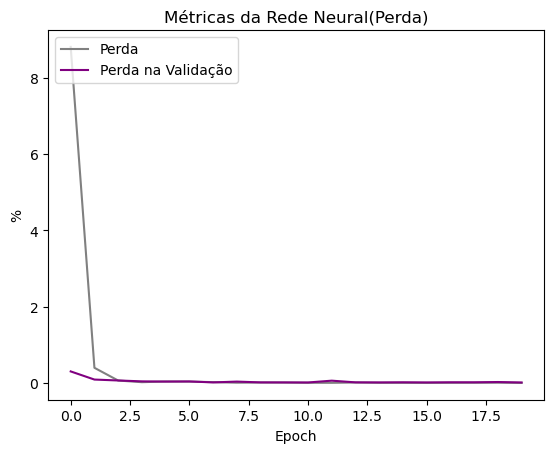

In [ ]:
plt.plot(historym.history['loss'], color='grey', label='Perda')
plt.plot(historym.history['val_loss'], color='purple', label='Perda na Validação')
plt.title('Métricas da Rede Neural(Perda)')
plt.ylabel('%')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

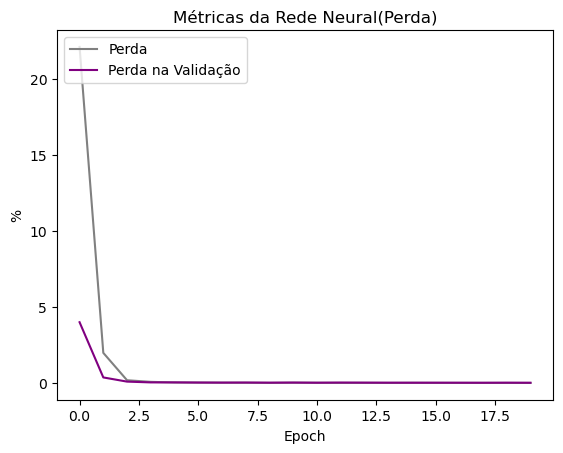

In [ ]:
plt.plot(historym2.history['loss'], color='grey', label='Perda')
plt.plot(historym2.history['val_loss'], color='purple', label='Perda na Validação')
plt.title('Métricas da Rede Neural(Perda)')
plt.ylabel('%')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

### Testando e avaliando

In [ ]:
y_predx = cnnx.predict(test)
y_predx = (y_predx >= 0.5).reshape(-1,)

2023-04-26 09:33:50.139123: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


12/12 [==============================] - 41s 4s/step


In [ ]:
y_predi = cnni.predict(test)
y_predi = (y_predi >= 0.5).reshape(-1,)

2023-04-25 14:23:02.121958: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-25 14:23:03.502661: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 37s 3s/step


In [ ]:
y_predm = cnnm.predict(test)
y_predm = (y_predm >= 0.5).reshape(-1,)

2023-04-25 16:57:25.263826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-25 16:57:25.788490: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 11s 787ms/step


In [ ]:
y_predm2 = cnnm2.predict(test)
y_predm2 = (y_predm2 >= 0.5).reshape(-1,)

2023-04-25 17:48:32.703742: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-25 17:48:33.397389: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 18s 1s/step


In [ ]:
y_actualx = test.classes[test.index_array]

In [ ]:
y_actuali = test.classes[test.index_array]

In [ ]:
y_actualm = test.classes[test.index_array]

In [ ]:
y_actualm2 = test.classes[test.index_array]

#### Matriz de confusão

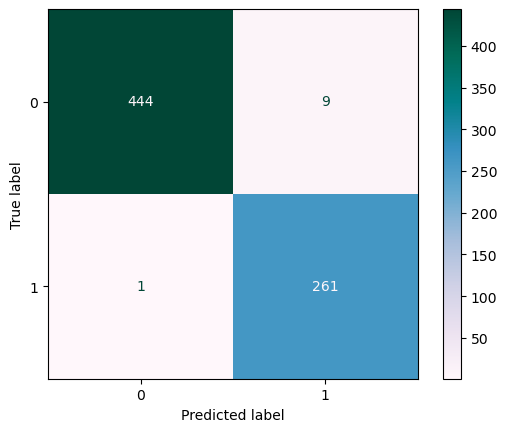

In [ ]:
cmx = metrics.confusion_matrix(y_actualx, y_predx)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cmx)
disp.plot(cmap='PuBuGn')
plt.show()

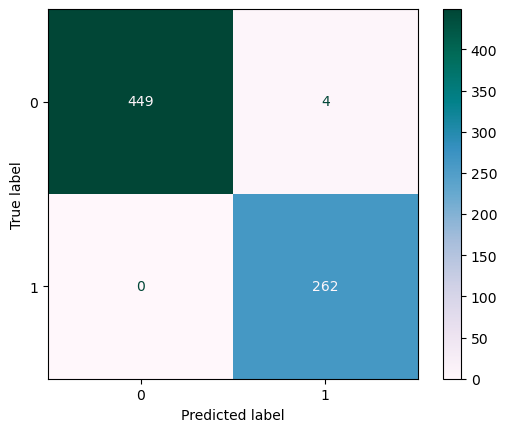

In [ ]:
cmi = metrics.confusion_matrix(y_actuali, y_predi)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cmi)
disp.plot(cmap='PuBuGn')
plt.show()

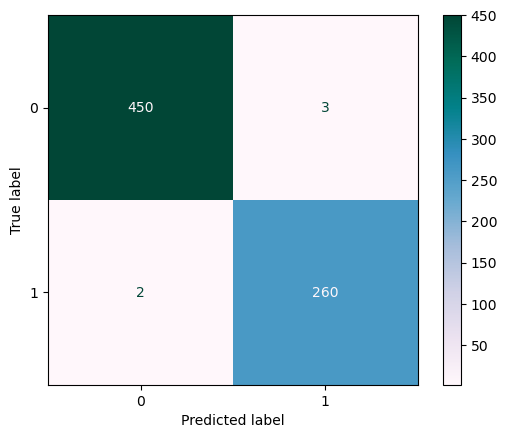

In [ ]:
cmm = metrics.confusion_matrix(y_actualm, y_predm)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cmm)
disp.plot(cmap='PuBuGn')
plt.show()

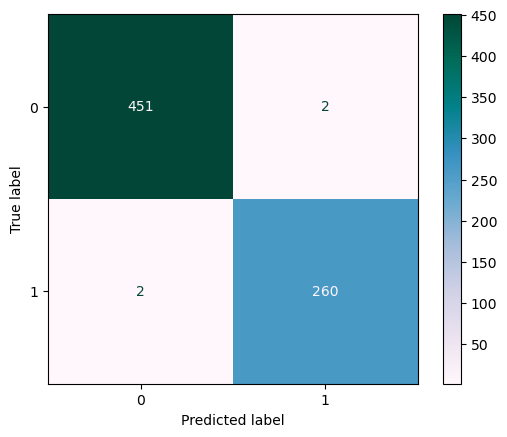

In [ ]:
cmm2 = metrics.confusion_matrix(y_actualm2, y_predm2)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cmm2)
disp.plot(cmap='PuBuGn')
plt.show()

#### Relatório de classificação

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_actualx, y_predx, digits=4))

              precision    recall  f1-score   support

           0     0.9978    0.9801    0.9889       453
           1     0.9667    0.9962    0.9812       262

    accuracy                         0.9860       715
   macro avg     0.9822    0.9882    0.9850       715
weighted avg     0.9864    0.9860    0.9861       715



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_actuali, y_predi, digits=4))

              precision    recall  f1-score   support

           0     1.0000    0.9912    0.9956       453
           1     0.9850    1.0000    0.9924       262

    accuracy                         0.9944       715
   macro avg     0.9925    0.9956    0.9940       715
weighted avg     0.9945    0.9944    0.9944       715



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_actualm, y_predm, digits=4))

              precision    recall  f1-score   support

           0     0.9956    0.9934    0.9945       453
           1     0.9886    0.9924    0.9905       262

    accuracy                         0.9930       715
   macro avg     0.9921    0.9929    0.9925       715
weighted avg     0.9930    0.9930    0.9930       715



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_actualm2, y_predm2, digits=4))

              precision    recall  f1-score   support

           0     0.9956    0.9956    0.9956       453
           1     0.9924    0.9924    0.9924       262

    accuracy                         0.9944       715
   macro avg     0.9940    0.9940    0.9940       715
weighted avg     0.9944    0.9944    0.9944       715

